In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import itertools
from itertools import groupby
import os

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="1,2"
%matplotlib inline

# 1. Data Load
### 전처리 width, height, input_channel 정의

In [5]:
from load_data import load_data,class_breakdown

In [6]:
#data_name ="EEG"
data_name ="HAR"

data_name ="UWaveGestureLibraryAll"
trainx, testx,trainy,testy,batch_size = load_data(data_name =data_name)

Load data UWaveGestureLibraryAll
batch size:64
train data (3582, 945),(3582,)
test data (896, 945),(896,)


In [7]:
class_breakdown(trainy)
class_breakdown(testy)

Class=1, total=437, percentage=12.200
Class=2, total=452, percentage=12.619
Class=3, total=454, percentage=12.674
Class=4, total=450, percentage=12.563
Class=5, total=433, percentage=12.088
Class=6, total=449, percentage=12.535
Class=7, total=447, percentage=12.479
Class=8, total=460, percentage=12.842
Class=1, total=122, percentage=13.616
Class=2, total=108, percentage=12.054
Class=3, total=106, percentage=11.830
Class=4, total=110, percentage=12.277
Class=5, total=127, percentage=14.174
Class=6, total=111, percentage=12.388
Class=7, total=112, percentage=12.500
Class=8, total=100, percentage=11.161


In [8]:
hot_encoded_y_train = np.asarray(pd.get_dummies(np.asarray(trainy.flatten())))
hot_encoded_y_test = np.asarray(pd.get_dummies(np.asarray(testy.flatten())))
print("y train shape: {}".format(hot_encoded_y_train.shape))
print("y test shape: {}".format(hot_encoded_y_test.shape))

y train shape: (3582, 8)
y test shape: (896, 8)


## 데이터 정규화

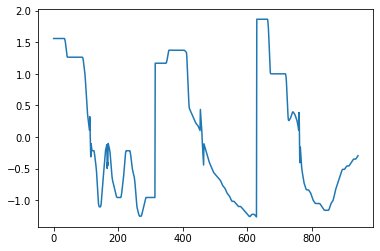

In [9]:
plt.plot(trainx[0])

In [10]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
trainx =TimeSeriesScalerMeanVariance().fit_transform(trainx)
testx =TimeSeriesScalerMeanVariance().fit_transform(testx)

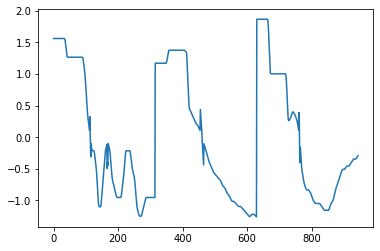

In [11]:
plt.plot(trainx[0])

In [12]:
trainX = trainx[:, np.newaxis, :]
trainY = hot_encoded_y_train

validX =testx[:len(testx)//2,np.newaxis,:]
validY= hot_encoded_y_test[:len(testx)//2]

testX = testx[len(testx)//2:,np.newaxis,:]
testY = hot_encoded_y_test[len(testx)//2:]

print ("trainX shape:{}".format(trainX.shape))
print ("trainY shape:{}".format(trainY.shape))
print ("validX shape:{}".format(validX.shape))
print ("validY shape:{}".format(validY.shape))
print ("testX shape:{}".format(testX.shape))
print ("testY shape:{}".format(testY.shape))

trainX shape:(3582, 1, 945, 1)
trainY shape:(3582, 8)
validX shape:(448, 1, 945, 1)
validY shape:(448, 8)
testX shape:(448, 1, 945, 1)
testY shape:(448, 8)


In [13]:
height = trainX.shape[1]
width = trainX.shape[2]
input_channel = trainX.shape[3]

print ("height {}".format(height))
print ("width {}".format(width))
print ("input_channel {}".format(input_channel))

height 1
width 945
input_channel 1


# 2. Training condition 정의

In [14]:
t_loss=[]
t_acc=[]

v_loss=[]
v_acc=[]

val_freq = 1
save_freq = 1
num_epochs= 500


std= 0.01
l_rate = 1e-5

In [15]:
train_history = pd.DataFrame(index=np.arange(0, num_epochs), columns=['epoch', 'loss', 'acc','timestamp'])
valid_history = pd.DataFrame(index=np.arange(0, num_epochs/val_freq),columns=['epoch', 'loss', 'acc','timestamp'])

# 3. model structure 정의

In [16]:
import tensorflow as tf

/home/gin908/paper_ready/py_36_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/gin908/paper_ready/py_36_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/gin908/paper_ready/py_36_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/gin908/paper_ready/py_36_env/lib/python3

In [17]:
class conv3_basic_CNN:
    def __init__(self, featuremap1, featuremap2, featuremap3,
                 conv1_size, conv2_size, conv3_size,
                 conv1_stride, conv2_stride, conv3_stride, 
                 conv1_channel, conv2_channel, conv3_channel,
                 pool1_size, pool2_size, pool3_size,
                 pool1_stride, pool2_stride, pool3_stride,
                 std=0.01, batch_size=64,width=500, height =1, input_channel=3, 
                 nb_classes=2, l_rate =1e-6,
                 reuse = False):
        self.std=std
        self.batch_size=batch_size
        self.height = height
        self.width = width
        self.input_channel = input_channel
        self.l_rate = l_rate
        
        self.feature1 = featuremap1
        self.feature2 = featuremap2
        self.feature3 = featuremap3
        
        self.conv1_size = conv1_size
        self.conv2_size = conv2_size
        self.conv3_size = conv3_size
        
        self.conv1_stride = conv1_stride
        self.conv2_stride = conv2_stride
        self.conv3_stride = conv3_stride
        
        self.conv1_channel = conv1_channel
        self.conv2_channel = conv2_channel
        self.conv3_channel = conv3_channel
        
        self.pool1_size = pool1_size
        self.pool2_size = pool2_size
        self.pool3_size = pool3_size
        
        self.pool1_stride = pool1_stride
        self.pool2_stride = pool2_stride
        self.pool3_stride = pool3_stride
        
        self.nb_classes = nb_classes

        with tf.name_scope('Classifier'):
            self.y_ = tf.placeholder(tf.float32, [None, self.nb_classes], name='truth')
            self.x =tf.placeholder(tf.float32, [None, 1,trainX.shape[2],trainX.shape[3]],name='x')
            self.keep_prob1 = tf.placeholder(tf.float32,name="keep_probability1")
            self.keep_prob2 = tf.placeholder(tf.float32,name="keep_probability2")
            self.keep_prob3 = tf.placeholder(tf.float32,name="keep_probability3")
            
            self.unit_bool1 = tf.placeholder(tf.float32, [None, 1,self.feature1,self.conv1_channel], name="unit_bool1")
            self.unit_bool2 = tf.placeholder(tf.float32, [None, 1,self.feature2,self.conv2_channel], name="unit_bool2")
            self.unit_bool3 = tf.placeholder(tf.float32, [None, 1,self.feature3,self.conv3_channel], name="unit_bool3")

        # keep prob가 1보다 작으면, 드랍아웃을 한다는 의미
        #self.dropout_bool = True#tf.cond(self.keep_prob < 1.0, lambda: tf.constant(True), lambda: tf.constant(False))
        
        self.logits = self.build_model()

        # Define loss and optimizer, minimize the squared error
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits = self.y, labels= self.y_)
        self.cost = tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.l_rate).minimize(self.cost)

        self.correct_pred = tf.equal(tf.argmax(self.y, 1), tf.argmax(self.y_, 1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))

        init = tf.global_variables_initializer()

        # Launch the session
        self.session_conf = tf.ConfigProto()
        self.session_conf.gpu_options.allow_growth = True
        self.sess = tf.InteractiveSession(config=self.session_conf)
        self.sess.run(init)

        self.saver = tf.train.Saver(max_to_keep=None)

    def build_model(self):
        xavier = tf.contrib.layers.xavier_initializer_conv2d()  
        self.conv1_weights = tf.get_variable(name="c1", initializer=xavier, shape=[1, self.conv1_size, trainX.shape[-1], conv1_channel])
        self.conv1_biases = tf.Variable(tf.zeros([conv1_channel]))
        self.conv2_weights = tf.get_variable(name="c2", initializer=xavier, shape=[1, self.conv2_size, self.conv1_channel, conv2_channel])
        self.conv2_biases = tf.Variable(tf.zeros([conv2_channel]))
        self.conv3_weights = tf.get_variable(name="c3", initializer=xavier, shape=[1, self.conv3_size, self.conv2_channel, conv3_channel])
        self.conv3_biases = tf.Variable(tf.zeros([conv3_channel]))
        self.fc1_weights = tf.Variable(tf.truncated_normal([1 * self.feature3  * self.conv3_channel, self.nb_classes], stddev=0.1))
        self.fc1_biases = tf.Variable(tf.zeros([self.nb_classes]))

        with tf.variable_scope('layer0'):
            #b, h, w, c
            self.reshaped_input = tf.reshape(self.x, [-1, 1, trainX.shape[2],trainX.shape[3]], name="absolute_input")
        # Convolutional Layer #1 and Pooling Layer #1
        with tf.variable_scope('layer1'):
            self.conv1 = tf.nn.conv2d(self.reshaped_input, self.conv1_weights, strides=[1, 1, self.conv1_stride, 1], padding='SAME')
            self.relu1 = tf.nn.relu(tf.nn.bias_add(self.conv1, self.conv1_biases))
            self.dropout1 = tf.nn.dropout(self.relu1, self.keep_prob1)
            self.pool1 =  tf.multiply(tf.nn.max_pool(self.dropout1, ksize=[1, 1, self.pool1_size, 1], strides=[1, 1, self.pool1_stride, 1],  padding='VALID'),
                                      self.unit_bool1)
            

        # Convolutional Layer #1 and Pooling Layer #2
        with tf.variable_scope('layer2'):
            self.conv2 = tf.nn.conv2d(self.pool1, self.conv2_weights, strides=[1, 1, self.conv2_stride, 1], padding='SAME')
            self.relu2 = tf.nn.relu(tf.nn.bias_add(self.conv2, self.conv2_biases))
            self.dropout2 = tf.nn.dropout(self.relu2, self.keep_prob2)
            self.pool2 =  tf.multiply(tf.nn.max_pool(self.dropout2, ksize=[1, 1, self.pool2_size, 1], strides=[1, 1, self.pool2_stride, 1],  padding='VALID'),
                                      self.unit_bool2)

        #Convolutional Layer #1 and Pooling Layer #3
        with tf.variable_scope('layer3'):
            self.conv3 = tf.nn.conv2d(self.pool2, self.conv3_weights, strides=[1, 1, self.conv3_stride, 1], padding='SAME')
            self.relu3 = tf.nn.relu(tf.nn.bias_add(self.conv3, self.conv3_biases))
            self.dropout3 = tf.nn.dropout(self.relu3, self.keep_prob3)
            self.pool3 =  tf.multiply(tf.nn.max_pool(self.dropout3, ksize=[1, 1, self.pool3_size, 1], strides=[1, 1, self.pool3_stride, 1],  padding='VALID'),
                                      self.unit_bool3)

        # Dense Layer with Relu
        with tf.variable_scope('layer4'):
            self.pool_shape = self.pool3.get_shape().as_list()
            self.reshaped = tf.reshape(self.pool3, [-1, self.pool_shape[1] * self.pool_shape[2] * self.pool_shape[3]])
            self.y = tf.add(tf.matmul(self.reshaped, self.fc1_weights), self.fc1_biases, name="absolute_output")
            self.prediction = tf.nn.softmax(self.y)
            
        return self.y


    def train(self, data, target):
        opt, cost ,acc = self.sess.run((self.optimizer,self.cost, self.accuracy ), 
                             feed_dict={self.y_: target,
                                        self.x: data,
                                       self.keep_prob1: 1.0,
                                       self.keep_prob2: 1.0,
                                       self.keep_prob3: 1.0,
                                       self.unit_bool1 : true_unit_bool1,
                                       self.unit_bool2 : true_unit_bool2,
                                       self.unit_bool3 : true_unit_bool3})
        return cost,acc

    def test(self, data, target):
        cost,acc = self.sess.run((self.cost,self.accuracy),
                             feed_dict={self.y_: target,
                                        self.x: data,
                                        self.keep_prob1: 1.0,
                                       self.keep_prob2: 1.0,
                                       self.keep_prob3: 1.0,
                                       self.unit_bool1 : true_unit_bool1,
                                       self.unit_bool2 : true_unit_bool2,
                                       self.unit_bool3 : true_unit_bool3})
        return cost,acc

    def get_output(self, output,data, keep_prob):
        output =  self.sess.run((output), feed_dict={self.x: data,self.keep_prob1: 1.0,
                                       self.keep_prob2: 1.0,
                                       self.keep_prob3: 1.0,
                                       self.unit_bool1 : true_unit_bool1,
                                       self.unit_bool2 : true_unit_bool2,
                                       self.unit_bool3 : true_unit_bool3})
        return output
    
    def predict(self, data, keep_prob):

        prediction =  self.sess.run((self.prediction), feed_dict={self.x: data,self.keep_prob1: 1.0,
                                       self.keep_prob2: 1.0,
                                       self.keep_prob3: 1.0,
                                       self.unit_bool1 : true_unit_bool1,
                                       self.unit_bool2 : true_unit_bool2,
                                       self.unit_bool3 : true_unit_bool3})
        return prediction

    def save(self, save_path='./model.ckpt'):
        saved_path = self.saver.save(self.sess, save_path)
        print("Model saved in file: %s"%saved_path)

    def load(self, load_path = './model.ckpt'):
        self.saver.restore(self.sess, load_path)
        print("Model restored")

    def terminate(self):
        self.sess.close()
        tf.reset_default_graph()

In [18]:
from numpy import unique
nb_classes =trainY.shape[1]
print (nb_classes)

8


<font color='red'> turn off 구조는 마지막 convolution layer activation output 에 weight를 elementwise multiply 구조.
train, test시에는 이 weight를 모두 1로 고정하며,
prdiction 시에는 convolution layer activation output에서 상위 T%를 turn off 시키며 accuracy의 변화가 A 이상인 경우를
threshold로 정하기 위해 이러한 모델 구조가 설정되었습니다.</font>

<font color='blue'> CNN_MC_dropout_last_conv_turnoff</font> 모델은 상위 T%의 output을 가지는 last convolution output을 0으로 turn off 시키는 구조입니다.

반면, <font color='blue'> CNN_MC_dropout_input_turnoff</font> 모델은 상위 T%의 output을 가지는 last convolution output에 매칭되는(하이라이트 되는 인풋)을 0으로 turn off 시키는 구조입니다.

In [19]:
import math
if data_name in ["HAR","EEG"]:
    conv1_channel = 32
    conv2_channel = 64
    conv3_channel = 128

    ###### conv1
    conv1_size = 7
    conv1_pad = int((conv1_size -1) /2)
    conv1_stride = 2

    pool1_size = 4
    pool1_pad = 0
    pool1_stride = 2

    ###### conv2
    conv2_size = 5
    conv2_pad = int((conv2_size -1) /2)
    conv2_stride = 1

    pool2_size = 4
    pool2_pad = 0
    pool2_stride = 2

    ###### conv3
    conv3_size = 3
    conv3_pad = int((conv3_size -1) /2)
    conv3_stride = 1

    pool3_size = 2
    pool3_pad = 0
    pool3_stride = 1
elif data_name in "UWaveGestureLibraryAll":
    conv1_channel = 32
    conv2_channel = 64
    conv3_channel = 128

    ###### conv1
    conv1_size = 15
    conv1_pad = int((conv1_size -1) /2)
    conv1_stride = 2

    pool1_size = 8
    pool1_pad = 0
    pool1_stride = 4

    ###### conv2
    conv2_size = 11
    conv2_pad = int((conv2_size -1) /2)
    conv2_stride = 1

    pool2_size = 4
    pool2_pad = 0
    pool2_stride = 2

    ###### conv3
    conv3_size = 7
    conv3_pad = int((conv3_size -1) /2)
    conv3_stride = 1

    pool3_size = 4
    pool3_pad = 0
    pool3_stride = 2

In [20]:
conv1_idx_list=[]
for conv1_idx in range(0,trainX.shape[2],conv1_stride):
    conv1_idx_list.append(np.arange(max(conv1_idx-(conv1_size//2),0), min(conv1_idx+(conv1_size//2) +1 ,trainX.shape[2])))

if conv1_idx < (trainX.shape[2]-1):
    for data_idx in np.arange(conv1_idx+1, trainX.shape[2]):
        conv1_idx_list.append(np.array([data_idx]))
    
print(len(conv1_idx_list))


pool1_idx_list=[]
for pool1_idx in range(0,len(conv1_idx_list)-(pool1_size-1), pool1_stride):
    temp_idx=[]
    for conv1_idx in np.arange(max(pool1_idx,0), min(pool1_idx+pool1_size ,len(conv1_idx_list))):
        temp_idx.extend(conv1_idx_list[conv1_idx])
    pool1_idx_list.append(list(sorted(set(temp_idx))))

if (pool1_idx + pool1_size) < (len(conv1_idx_list)-1):
    for conv1_idx in np.arange(pool1_idx+pool1_size, len(conv1_idx_list)):
        pool1_idx_list.append(conv1_idx_list[conv1_idx])
print(len(pool1_idx_list))



conv2_idx_list=[]
for conv2_idx in range(0,len(pool1_idx_list), conv2_stride):
    temp_idx=[]
    for pool1_idx in np.arange(max(conv2_idx-(conv2_size//2),0), min(conv2_idx+(conv2_size//2) +1 ,len(pool1_idx_list))):
        temp_idx.extend(pool1_idx_list[pool1_idx])
    conv2_idx_list.append(list(sorted(set(temp_idx))))


if conv2_idx < (len(pool1_idx_list)-1):
    print("add")
    for pool1_idx in np.arange(conv2_idx+1, len(pool1_idx_list)):
        conv2_idx_list.append(pool1_idx_list[pool1_idx])
print(len(conv2_idx_list))


pool2_idx_list=[]
for pool2_idx in range(0,len(conv2_idx_list)-(pool2_size-1), pool2_stride):
    temp_idx=[]
    for conv2_idx in np.arange(max(pool2_idx,0), min(pool2_idx+pool2_size ,len(conv2_idx_list))):
        temp_idx.extend(conv2_idx_list[conv2_idx])
    pool2_idx_list.append(list(sorted(set(temp_idx))))

if (pool2_idx + pool2_size) < (len(conv2_idx_list)-1):
    for conv2_idx in np.arange(pool2_idx+pool2_size, len(conv2_idx_list)):
        pool2_idx_list.append(conv2_idx_list[conv2_idx])
print(len(pool2_idx_list))




conv3_idx_list=[]
for conv3_idx in range(0,len(pool2_idx_list), conv3_stride):
    temp_idx=[]
    for pool2_idx in np.arange(max(conv3_idx-(conv3_size//2),0), min(conv3_idx+(conv3_size//2) +1 ,len(pool2_idx_list))):
        temp_idx.extend(pool2_idx_list[pool2_idx])
    conv3_idx_list.append(list(sorted(set(temp_idx))))


if conv3_idx < (len(pool2_idx_list)-1):
    print("add")
    for pool2_idx in np.arange(conv3_idx+1, len(pool2_idx_list)):
        conv3_idx_list.append(pool2_idx_list[pool2_idx])
print(len(conv3_idx_list))


pool3_idx_list=[]
for pool3_idx in range(0,len(conv3_idx_list)-(pool3_size-1), pool3_stride):
    temp_idx=[]
    for conv3_idx in np.arange(max(pool3_idx,0), min(pool3_idx+pool3_size ,len(conv3_idx_list))):
        temp_idx.extend(conv3_idx_list[conv3_idx])
    pool3_idx_list.append(list(sorted(set(temp_idx))))

if (pool3_idx + pool3_size) < (len(conv3_idx_list)-1):
    for conv3_idx in np.arange(pool3_idx+pool3_size, len(conv3_idx_list)):
        pool3_idx_list.append(conv3_idx_list[conv3_idx])
print(len(pool3_idx_list))

473
117
117
57
57
27


In [21]:
pool1_pattern_len = np.max([len(x) for x in pool1_idx_list])
pool2_pattern_len = np.max([len(x) for x in pool2_idx_list])
pool3_pattern_len = np.max([len(x) for x in pool3_idx_list])

print("pool pattern length : pool1({}),pool2({}),pool3({})".format(pool1_pattern_len,
                                                                     pool2_pattern_len,
                                                                     pool3_pattern_len))

pool pattern length : pool1(29),pool2(133),pool3(277)


In [22]:
pool1_output_len = len(pool1_idx_list)
pool2_output_len = len(pool2_idx_list)
pool3_output_len = len(pool3_idx_list)

In [23]:

tf.reset_default_graph()

In [24]:
#if 'MC_dropout_model' in globals()
try:
    MC_dropout_model.sess.close()
except:
    pass
tf.reset_default_graph()
MC_dropout_model = conv3_basic_CNN(featuremap1=pool1_output_len, featuremap2=pool2_output_len, featuremap3=pool3_output_len,
                                      conv1_size=conv1_size, conv2_size=conv2_size, conv3_size=conv3_size,
                                      conv1_channel=conv1_channel, conv2_channel=conv2_channel, conv3_channel=conv3_channel,
                                       conv1_stride=conv1_stride, conv2_stride=conv2_stride, conv3_stride=conv3_stride,
                                       pool1_size=pool1_size, pool2_size=pool2_size, pool3_size=pool3_size,
                                       pool1_stride=pool1_stride, pool2_stride=pool2_stride, pool3_stride=pool3_stride,
                                       
                                      height=height,width= width, input_channel=input_channel ,nb_classes=nb_classes,
                                 std=std,batch_size=batch_size,l_rate=l_rate)


In [25]:
print (MC_dropout_model.reshaped_input)

print ('[layer1] - MC dropout')
print (MC_dropout_model.conv1)
print (MC_dropout_model.pool1)
print (MC_dropout_model.relu1)
print (MC_dropout_model.dropout1)
print ('[layer2] - MC dropout')
print (MC_dropout_model.conv2)
print (MC_dropout_model.pool2)
print (MC_dropout_model.relu2)
print (MC_dropout_model.dropout2)
print ('[layer3] - MC dropout')
print (MC_dropout_model.conv3)
print (MC_dropout_model.pool3)
print (MC_dropout_model.relu3)
print (MC_dropout_model.dropout3)


print ('[layer4]')
print (MC_dropout_model.reshaped)
print (MC_dropout_model.y)

Tensor("layer0/absolute_input:0", shape=(?, 1, 945, 1), dtype=float32)
[layer1] - MC dropout
Tensor("layer1/Conv2D:0", shape=(?, 1, 473, 32), dtype=float32)
Tensor("layer1/Mul:0", shape=(?, 1, 117, 32), dtype=float32)
Tensor("layer1/Relu:0", shape=(?, 1, 473, 32), dtype=float32)
Tensor("layer1/dropout/mul:0", shape=(?, 1, 473, 32), dtype=float32)
[layer2] - MC dropout
Tensor("layer2/Conv2D:0", shape=(?, 1, 117, 64), dtype=float32)
Tensor("layer2/Mul:0", shape=(?, 1, 57, 64), dtype=float32)
Tensor("layer2/Relu:0", shape=(?, 1, 117, 64), dtype=float32)
Tensor("layer2/dropout/mul:0", shape=(?, 1, 117, 64), dtype=float32)
[layer3] - MC dropout
Tensor("layer3/Conv2D:0", shape=(?, 1, 57, 128), dtype=float32)
Tensor("layer3/Mul:0", shape=(?, 1, 27, 128), dtype=float32)
Tensor("layer3/Relu:0", shape=(?, 1, 57, 128), dtype=float32)
Tensor("layer3/dropout/mul:0", shape=(?, 1, 57, 128), dtype=float32)
[layer4]
Tensor("layer4/Reshape:0", shape=(?, 3456), dtype=float32)
Tensor("layer4/absolute_outp

# 4. Training

In [26]:
import time
import os
import numpy as np

In [27]:
save_path = './model/'+data_name
model_name = data_name+"_CNN_conv3_"+str(l_rate)+'_'+str(batch_size)
print (model_name)

UWaveGestureLibraryAll_CNN_conv3_1e-05_64


In [28]:
from training import get_batch

In [29]:
keep_prob =1.0

In [30]:
true_unit_bool1 = np.ones(pool1_output_len * conv1_channel).reshape(-1,1,pool1_output_len, conv1_channel)
true_unit_bool2 = np.ones(pool2_output_len * conv2_channel).reshape(-1,1,pool2_output_len, conv2_channel)
true_unit_bool3 = np.ones(pool3_output_len * conv3_channel).reshape(-1,1,pool3_output_len, conv3_channel)

for epoch in range(num_epochs):#range(num_epochs):##
    
    loss = 0
    acc=0
    train_batches = 0
    start_time = time.time()   
    
    for batch in get_batch(X=trainX, Y=trainY, nb_classes = nb_classes, batch_size=batch_size):
        train_in, train_target = batch
        train_batches += 1.0 
        loss1 ,acc1 = MC_dropout_model.train(data=train_in,target= train_target)
        loss = loss1+loss
        acc = acc1+acc
        if np.isnan(loss):
            print ('error')
            break
    t_loss.append(loss/train_batches)
    t_acc.append(acc/train_batches)
    
    train_history.loc[epoch] = [epoch, t_loss[epoch], t_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]
    if not os.path.exists(os.path.join(save_path, model_name)):
        os.mkdir( os.path.join(save_path, model_name))
    MC_dropout_model.save(os.path.join(save_path, model_name,str(epoch+1)+'.ckpt'))

    
    if(epoch+1)%val_freq ==0:
        acc=0
        loss = 0
        val_batches=0
        for batch in get_batch(X=validX, Y=validY, nb_classes = nb_classes, batch_size=batch_size):
            val_in, val_target = batch
            val_batches += 1.0 
            loss1 ,acc1 = MC_dropout_model.test(data=val_in,target= val_target)                                              
            loss = loss1+loss
            acc = acc1+acc
        
        v_acc.append(acc/val_batches)
        v_loss.append(loss/val_batches)
        valid_history.loc[epoch] = [epoch, v_loss[epoch], v_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]  
        
        print("  training loss:\t{:.6f}".format(t_loss[epoch]))
        print("  training acc:\t{:.3f}".format(t_acc[epoch]))
        print("  validation loss:\t{:.6f}".format(v_loss[epoch]))
        print("  validation acc:\t{:.3f}".format(v_acc[epoch]))


train_history.to_csv(os.path.join(save_path,model_name,  "history_train.csv"))
valid_history.to_csv(os.path.join(save_path,model_name,  "history_valid.csv"))

# 5.check the result

### with loss and accuracy graph

In [31]:
from visualization import plot_train_history

In [32]:
train_history = pd.read_csv(os.path.join(save_path,model_name,"history_train.csv"),index_col=0)
valid_history = pd.read_csv(os.path.join(save_path,model_name,"history_valid.csv"),index_col=0)

save ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/loss_graph.png
save ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/acc_graph.png


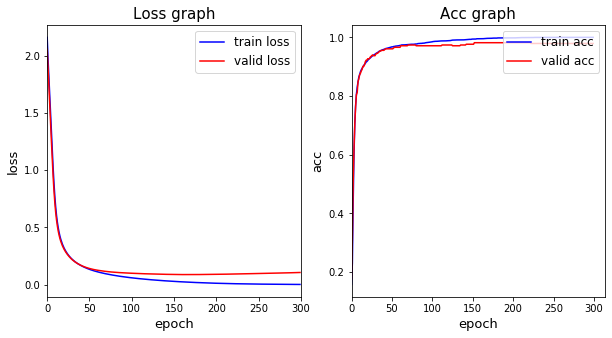

In [33]:
plot_train_history(train_df = train_history,
                   valid_df = valid_history,
                   save_path = os.path.join(save_path,model_name))

In [34]:
bestepoch = int(np.argmin(valid_history['loss'].values))
print( bestepoch)

error = valid_history.loc[bestepoch,'loss']
print ("error: {}".format(error))

MC_dropout_model.load(os.path.join(save_path,model_name,str(bestepoch)+'.ckpt'))

168
error: 0.0880859587341547
INFO:tensorflow:Restoring parameters from ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/168.ckpt
Model restored


In [35]:
valid_history.loc[bestepoch]

epoch                     168
loss                 0.088086
acc                  0.981771
timestamp    2020-02-06-22:56
Name: 168, dtype: object

import glob
for epoch in [x+1 for x in range(num_epochs) if (x+1) !=bestepoch]:
    for filename in glob.glob(os.path.join(save_path,model_name,str(epoch)+".*")):
        os.remove(filename) 

### with confusion matrix

In [36]:
from visualization import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [37]:
class_list = np.unique(trainy, return_counts=False, return_index=True)[0].astype(int)

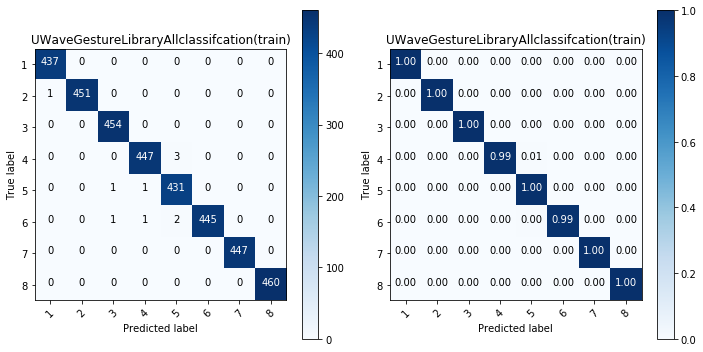

In [38]:
prediction = MC_dropout_model.predict(data=trainX,keep_prob=1.0)
prediction = np.argmax(prediction,axis=1)
target = np.argmax(trainY,axis=1)

plot_confusion_matrix(confusion_matrix(target,prediction),                      
    classes=class_list,
    title=data_name+'classifcation(train)')

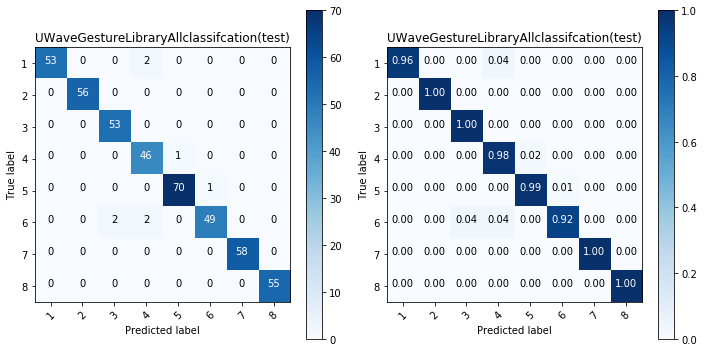

In [39]:
prediction = MC_dropout_model.predict(data=testX,keep_prob=1.0)
prediction = np.argmax(prediction,axis=1)
target = np.argmax(testY,axis=1)

plot_confusion_matrix(confusion_matrix(target,prediction),                      
    classes=class_list,
    title=data_name+'classifcation(test)')

## 클래스 정하기

In [40]:
pattern_class = [np.arange(1,nb_classes+1)]

## pattern 추출

last_weight = MC_dropout_model.sess.run([tf.trainable_variables()[-2]],feed_dict={})

In [41]:
pattern_length = np.max([len(x) for x in pool3_idx_list])
reindexed_relu_bool=[]

relu_output = MC_dropout_model.get_output(output = MC_dropout_model.pool3,data=trainX,keep_prob=1.0)

relu_output = relu_output.reshape(-1,1,pool3_output_len,conv3_channel)
temp_threshold = np.percentile(relu_output,99.5,[0,1,2])
relu_bool = (relu_output>temp_threshold).squeeze()     


for p,data_idx in enumerate(range(len(trainX))):
    for output_c in range(conv3_channel):
        if len([x for x in relu_bool[p,:,output_c].flatten() if x]):
            index = []
            for idx in [i for i,x in enumerate(relu_bool[p,:,output_c].flatten()) if x]:    
                reindexed_relu_bool.append([data_idx,output_c,idx])

### 패턴 중복 count

In [42]:
pattern_idx_df = pd.DataFrame(reindexed_relu_bool,columns=["data_idx","output_channel","pattern_xs"])
groups = pattern_idx_df.groupby(["data_idx","pattern_xs"])#["output_channel"].apply(list)
pattern_repetitive_idx_df = groups["output_channel"].apply(list).reset_index(name='output_channel')

In [43]:
pattern_repetitive_idx_df.head()

,data_idx,pattern_xs,output_channel
0,0,0,[103]
1,1,24,[101]
2,1,25,"[47, 101, 106]"
3,1,26,"[30, 47, 60, 70, 71, 79, 101, 106, 127]"
4,2,0,[103]


In [44]:
consecutive_pattern=[]
pattern_id=0

data_idx = pattern_repetitive_idx_df.loc[:,"data_idx"].values.tolist()
output_channel = pattern_repetitive_idx_df.loc[:,"output_channel"].values.tolist()
pattern_xs = pattern_repetitive_idx_df.loc[:,"pattern_xs"].values.tolist()

for d_idx, output_c,  p_xs in zip(data_idx, output_channel, pattern_xs):
    for input_c in range(trainX.shape[3]):
        pattern_dict={}
        pattern_dict["pattern_id"]= pattern_id
        pattern_dict["data_idx"] = d_idx
        pattern_dict["output_channel"] = output_c
        pattern_dict["input_channel"] = input_c
        pattern_dict["pattern_xs"]= pool3_idx_list[p_xs]

        short_pattern = pattern_length - len(trainX[d_idx,0,pool3_idx_list[p_xs],input_c])

        if short_pattern:
            if pool3_idx_list[p_xs][0]==0:
                extended_xs= np.concatenate((np.arange(-short_pattern,0),pool3_idx_list[p_xs]))
                pattern_dict["pattern_ys"] = np.concatenate((np.zeros(short_pattern),(trainX[d_idx,0,pool3_idx_list[p_xs],input_c])))
            elif pool3_idx_list[p_xs][-1] == (trainX.shape[2]-1):
                pattern_dict["pattern_ys"] = np.concatenate((trainX[d_idx,0,pool3_idx_list[p_xs],input_c],np.zeros(short_pattern)))
        else:
            pattern_dict["pattern_ys"] = trainX[d_idx,0,pool3_idx_list[p_xs],input_c]

            consecutive_pattern.append(pattern_dict)
            pattern_id+=1

In [45]:
a = [len(x['pattern_ys']) for x in consecutive_pattern]
print("pattern length:{}".format(np.unique(a)))

pattern length:[277]


# clustering parameter

In [63]:
n_cluster=12

In [64]:
main_title = "{},layer3,class{},cluster{}".format(data_name,pattern_class,n_cluster)
print(main_title)

UWaveGestureLibraryAll,layer3,class[array([1, 2, 3, 4, 5, 6, 7, 8])],cluster12


In [65]:
np.save('./pattern/{}-0.05%.npy'.format(main_title), consecutive_pattern)

consecutive_pattern = np.load('./pattern/{}-0.05%.npy'.format(main_title),allow_pickle=True)

In [66]:
pattern =[x['pattern_ys'] for x in consecutive_pattern]
pattern_weight = np.asarray([len(x['output_channel']) for x in consecutive_pattern])

pattern_weight *= pattern_weight

# clustering

In [67]:
from sklearn import cluster, mixture

'''
This criterion gives us an estimation on how much is good the GMM in terms of predicting the data we actually have. 
The lower is the BIC, the better is the model to actually predict the data we have, 
and by extension, the true, unknown, distribution.
'''

ax = plt.subplot(3,1,1)

n_components = np.arange(1, 100)
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(pattern) for n in n_components]

ax.plot(n_components, [m.bic(np.asarray(pattern)) for m in models], label='BIC')
ax.plot(n_components, [m.aic(np.asarray(pattern)) for m in models], label='AIC')
ax.legend(loc='best')
ax.set_xlabel('n_components');

#ax2 = plt.subplot(3,1,2)
#ax2.plot(n_components, [m.bic(np.asarray(pattern)) for m in models], label='BIC')
#ax2.plot(n_components, [m.aic(np.asarray(pattern)) for m in models], label='AIC')
#ax.legend(loc='best')
#ax.set_xlabel('n_components');

In [68]:
from tslearn.clustering import KShape

pattern =TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(pattern).squeeze()

In [69]:
default_base = {'eps': .3,
            'n_clusters': n_cluster}

params = default_base.copy()

params['n_clusters']=n_cluster

k_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
weighted_k_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full',random_state=0)
kshape = KShape(n_clusters=params['n_clusters'], n_init=1, verbose=True,random_state=0)
#dbscan = cluster.DBSCAN(min_samples = params['n_clusters'])
#spectral = cluster.SpectralClustering(n_clusters=params['n_clusters'])
#spectral_n = cluster.SpectralClustering(n_clusters=params['n_clusters'],affinity='nearest_neighbor')

clustering_algorithms = (
    ('KMeans', k_means),
    ('MiniBatch_weighted_KMeans', weighted_k_means),
    ('GMM',gmm),
    ('KShape',kshape)
    #('DBSCAB',dbscan)
    #('Spectral_RBF', spectral),
    #('Spectral_NN', spectral_n),
    )

cluster_label_df = pd.DataFrame(index = range(0,len(pattern)))

In [70]:
standardized_pattern = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(pattern).squeeze()

In [71]:
for name, algorithm in clustering_algorithms:
    
    start_time = time.time()   
    if "weighted" in name:
        algorithm.fit(standardized_pattern,sample_weight= pattern_weight)
    #elif "Spectral" in name:
    #    algorithm.fit(pattern)
    else:
        algorithm.fit(standardized_pattern)

    if hasattr(algorithm, 'labels_'):
        vars()[str(name)+"_pred"] = algorithm.labels_.astype(np.int)
    else:
        vars()[str(name)+"_pred"] = algorithm.predict(standardized_pattern)
    print("{} fitting ({}s)".format(name,round((time.time()- start_time),3)))
    cluster_label_df.loc[:,str(name)+"_label"] = eval(str(name)+"_pred")

cluster_label_df.to_csv('./pattern/{}_label'.format(main_title,n_cluster))

KMeans fitting (0.28s)
MiniBatch_weighted_KMeans fitting (0.128s)
GMM fitting (112.474s)
0.050 --> 0.047 --> 0.046 --> 0.045 --> 0.045 --> 0.044 --> 0.044 --> 0.044 --> 0.044 --> 0.044 --> 0.044 --> 0.044 --> 0.044 --> 0.044 --> 0.044 --> 0.044 --> 
KShape fitting (416.665s)


cluster_label_df= pd.read_csv('./pattern/{}_label'.format(main_title,n_cluster),index_col=0)

In [57]:
import random

In [58]:
cluster_label = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

============================KMeans============================


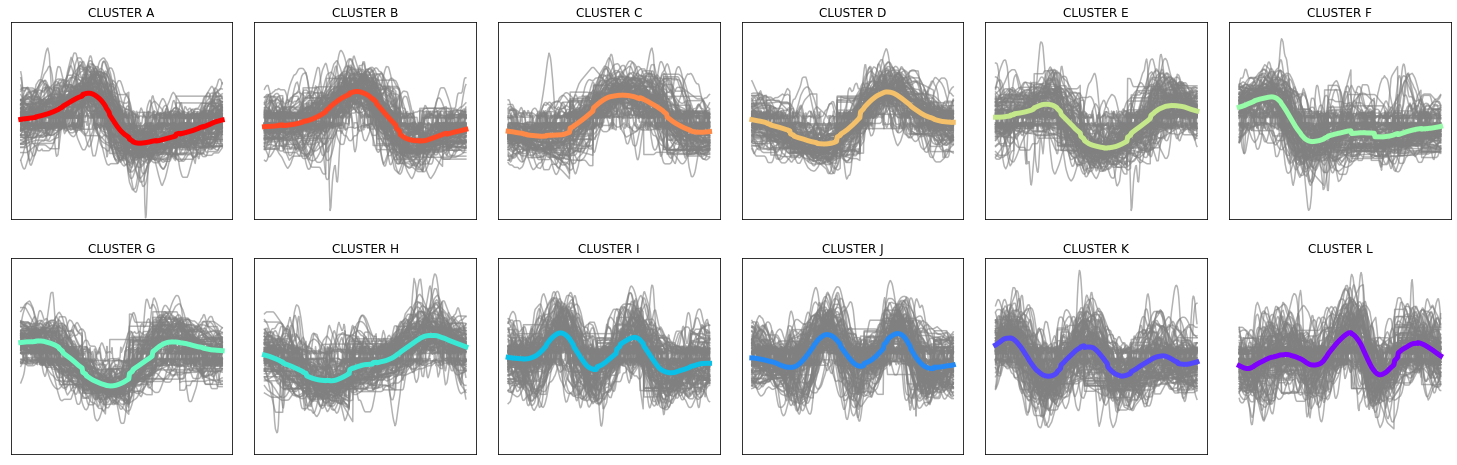

UWaveGestureLibraryAll,layer3,class[array([1, 2, 3, 4, 5, 6, 7, 8])],cluster12 saved at ./figure/UWaveGestureLibraryAll,layer3,class[array([1, 2, 3, 4, 5, 6, 7, 8])],cluster12_cluster_KMeans
============================MiniBatch_weighted_KMeans============================


<Figure size 432x288 with 0 Axes>

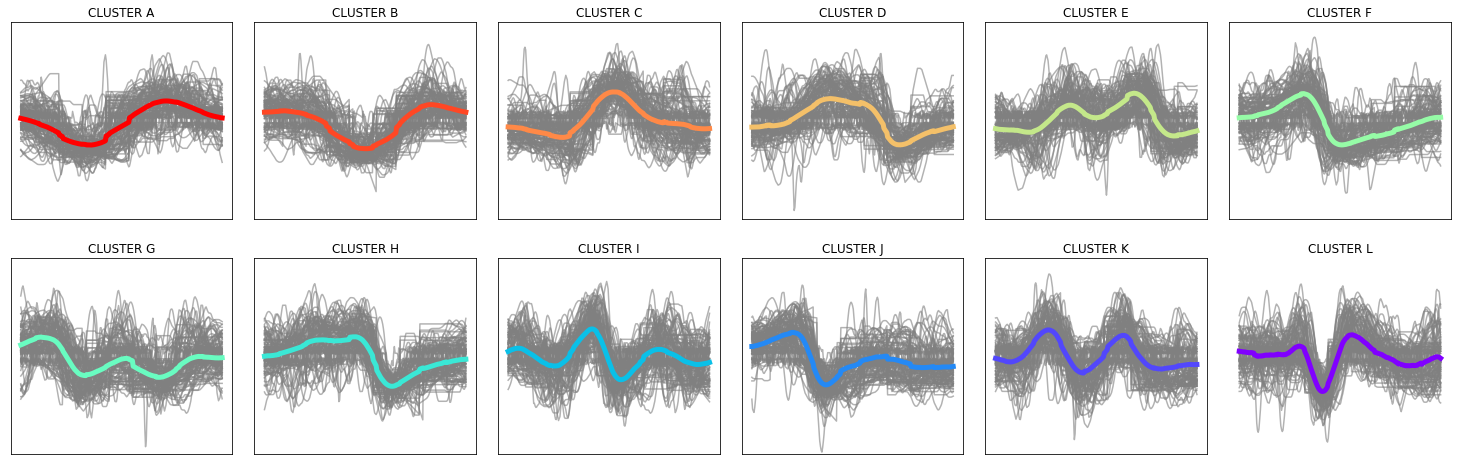

UWaveGestureLibraryAll,layer3,class[array([1, 2, 3, 4, 5, 6, 7, 8])],cluster12 saved at ./figure/UWaveGestureLibraryAll,layer3,class[array([1, 2, 3, 4, 5, 6, 7, 8])],cluster12_cluster_MiniBatch_weighted_KMeans
============================GMM============================


<Figure size 432x288 with 0 Axes>

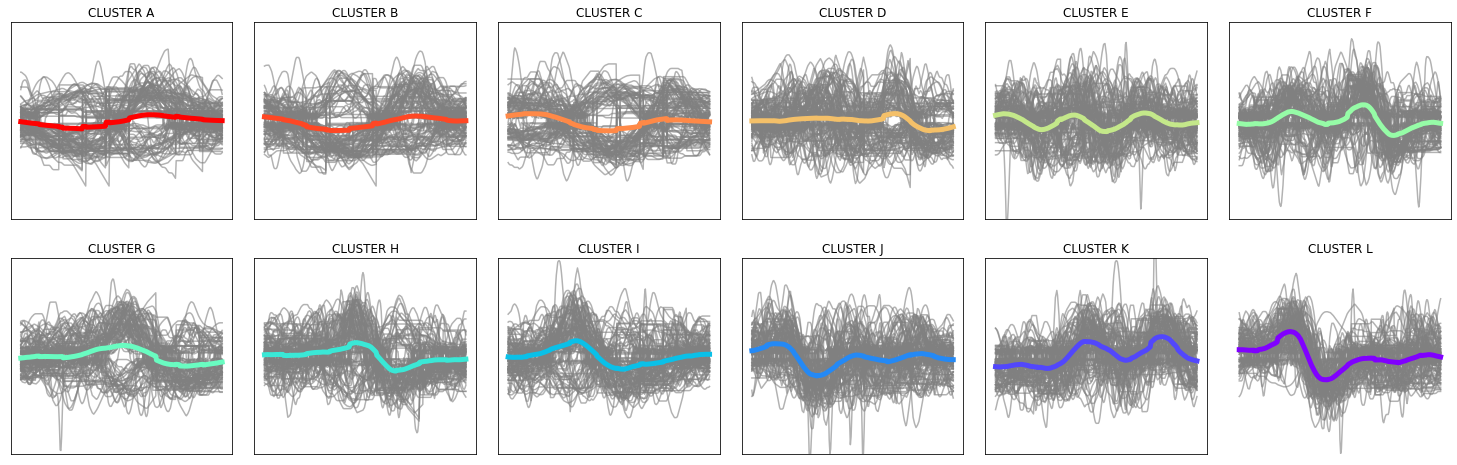

UWaveGestureLibraryAll,layer3,class[array([1, 2, 3, 4, 5, 6, 7, 8])],cluster12 saved at ./figure/UWaveGestureLibraryAll,layer3,class[array([1, 2, 3, 4, 5, 6, 7, 8])],cluster12_cluster_GMM
============================KShape============================


<Figure size 432x288 with 0 Axes>

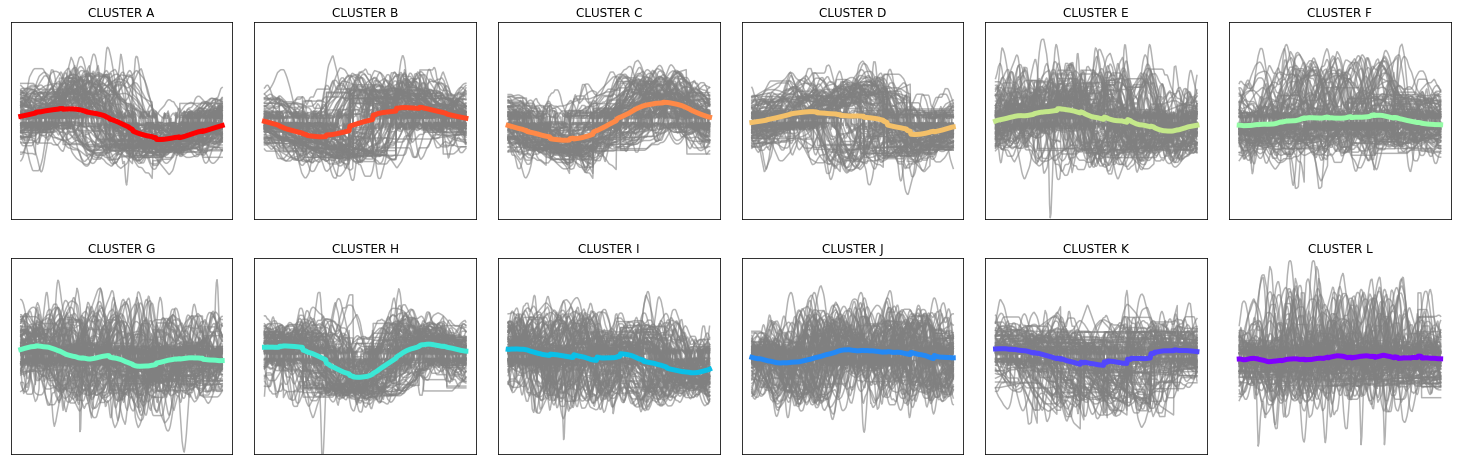

UWaveGestureLibraryAll,layer3,class[array([1, 2, 3, 4, 5, 6, 7, 8])],cluster12 saved at ./figure/UWaveGestureLibraryAll,layer3,class[array([1, 2, 3, 4, 5, 6, 7, 8])],cluster12_cluster_KShape


<Figure size 432x288 with 0 Axes>

In [72]:
from matplotlib.pyplot import cm

column=6
color = cm.rainbow(np.linspace(0,1,n_cluster))[::-1]

y_max = 5#np.abs(max(np.min(pattern), np.max(pattern), key=abs))
y_min = -y_max 
cluster_group = []
for name,algorithm in clustering_algorithms:
    fig = plt.figure(figsize=(20,(n_cluster//column*3)))
    save_path = '{}_cluster_{}'.format(main_title, name)
    print("============================"+name+"============================")
    sort_idx = cluster_label_df[name+"_label"].value_counts()
    for n in range(n_cluster): 
        group_idx = [i for i,x in enumerate(cluster_label_df.loc[:,name+"_label"].ravel()) if x == sort_idx.index[n]]
        group_pattern = np.array([pattern[idx] for idx in group_idx])
        group_pattern_mean = group_pattern.mean(axis=0)
        group_pattern_std = group_pattern.std(axis=0)
        
        if "KShape" in name:
            for c in group_idx:
                consecutive_pattern[c]["group"]=sort_idx.index[n]

            cluster_group.append({"group":sort_idx.index[n],"n":n,
                                 "color_idx":n,"mean":group_pattern_mean,"std":group_pattern_std})
            

        ax = plt.subplot(n_cluster//column,column,n+1)
        ax.set_yticks([])
        ax.set_xticks([])

        ax.plot(group_pattern[random.sample(range(len(group_pattern)),min(len(group_pattern),100))].T, color ='grey',alpha=0.6)
        #ax.plot(group_pattern.T, color =color[n],alpha=0.6)
        ax.plot(group_pattern_mean, color =color[n],alpha=1,linewidth=5)

        ax.set_title("CLUSTER {}".format(cluster_label[n]))
        #ax.set_title("{} cluster_{} : {}({:2.1f}%)".format(n, sort_idx.index[n],sort_idx.iloc[n],sort_idx.iloc[n]/len(pattern)*100))
        ax.set_ylim(y_min,y_max) 


    #fig.suptitle(main_title,y=1.0,size=12)
    plt.tight_layout()
    plt.axis('off'), plt.xticks([]), plt.yticks([])
    #plt.tight_layout()
    plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0.2, wspace = 0.1)
    plt.show()
    
    plt.savefig(os.path.join('./figure',save_path))
    print("{} saved at {}".format(main_title,os.path.join('./figure',save_path)))
    #plt.close()

In [73]:
c_std=[]
for sc in range(n_cluster):
    class_idx = [i for i,x in enumerate(KShape_pred) if x == sort_idx.index[sc]]
    sort_idx = cluster_label_df['KShape_label'].value_counts()
    class_pattern = np.array([pattern[idx] for idx in class_idx])
    standardized_class_pattern =TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(class_pattern).squeeze()
    c_std.append(class_pattern.std(0).mean() * np.sqrt(len(class_pattern)))

In [74]:
from scipy.stats import entropy

In [75]:
plt.style.available

['classic',
 'seaborn-dark',
 '_classic_test',
 'dark_background',
 'ggplot',
 'seaborn-white',
 'seaborn-paper',
 'seaborn-muted',
 'seaborn-poster',
 'Solarize_Light2',
 'seaborn-dark-palette',
 'seaborn-notebook',
 'grayscale',
 'fivethirtyeight',
 'fast',
 'seaborn-deep',
 'bmh',
 'seaborn-bright',
 'seaborn-talk',
 'seaborn-darkgrid',
 'seaborn-ticks',
 'seaborn-whitegrid',
 'tableau-colorblind10',
 'seaborn-pastel',
 'seaborn',
 'seaborn-colorblind']

In [ ]:
plt.style.use('seaborn-white')

sub_cluster_group = []

whole_sub_class =0 
for sup_cluster in range(n_cluster):
    
    sub_ncluster = int(np.sqrt(c_std)[sup_cluster])
    subgroup_idx = [i for i,x in enumerate(KShape_pred) if x == sort_idx.index[sup_cluster]]
    class_pattern = np.array([pattern[idx] for idx in subgroup_idx])

    sub_gmm = mixture.GaussianMixture(n_components=sub_ncluster, covariance_type='full',random_state=0)
    new_label = sub_gmm.fit_predict(class_pattern)
    fig = plt.figure(figsize=(5,2*(math.ceil(sub_ncluster/2))))
    plt.axis('off'), plt.xticks([]), plt.yticks([])
    plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0.1, wspace = 0.1)
    for c in range(sub_ncluster):
        subclass_idx = [i for i,x in enumerate(new_label) if x == c]
        global_subclass_idx = [subgroup_idx[i] for i,x in enumerate(new_label) if x == c]
        subclass_pattern = np.array([class_pattern[idx] for idx in subclass_idx])
        subclass_pattern_mean = subclass_pattern.mean(0)
        subclass_pattern_std = entropy(sub_gmm.predict_proba(class_pattern).T, base=2).mean()
        if (subclass_pattern.std(0).max()<1.6):
            for k in global_subclass_idx:
                consecutive_pattern[k]["subgroup"]=whole_sub_class
            
            sub_cluster_group.append({"group":sort_idx.index[sup_cluster],
                                  "subgroup":whole_sub_class,
                                  "mean":subclass_pattern_mean,
                                  "std": subclass_pattern_std,
                                 'mass': len(class_pattern)})
            whole_sub_class+=1
        else:
            for k in global_subclass_idx:
                consecutive_pattern[k]["subgroup"]=np.nan
        ax = plt.subplot((math.ceil(sub_ncluster/2)),2,c+1)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_title("SUB {}".format(c+1))
        if (subclass_pattern.std(0).max()<1.6):#((subclass_pattern_weight.max())>np.quantile(pattern_weight,0.75) or (subclass_pattern_weight.sum() > len(class_pattern)*(1.0/sub_ncluster))):
            ax.plot(np.asarray(random.sample(list(subclass_pattern),min(200,len(subclass_pattern)))).T, color = color[sup_cluster])
            #ax.text(0,4,"max:{}\nsum:{}".format(subclass_pattern_weight.max(),round(subclass_pattern_weight.sum(),2)))
            ax.plot(subclass_pattern_mean, color ='black',alpha=0.5,linewidth=5)
        else:
            ax.set_facecolor('grey')
            print("less")
            ax.plot(np.asarray(subclass_pattern).T, color = color[sup_cluster])
            #ax.text(0,4,"max:{}\nsum:{}".format(subclass_pattern_weight.max(),round(subclass_pattern_weight.sum(),2)))
        ax.set_ylim(y_min,y_max)

    plt.tight_layout()
    plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0.1, wspace = 0.1)

# Unit-LRP with uncertainty

In [ ]:
from tensorflow.python.ops import nn_ops, gen_nn_ops

In [ ]:
def lrp(F, lowest, highest, layer, unit_num, graph=None, return_flist=False):
    """
        Accepts a final output, and propagates back from there to compute LRP over a tensorflow graph. 
        Performs a Taylor Decomp at each layer to assess the relevances of each neuron at that layer
    """
    #Assumptions:
        #all conv strides are [1,1,1,1]
        #all pool strides are [1,2,2,1]
        #all pool/conv padding is SAME
        #only reshaping that happens is after a pool layer (pool -> fc) or a conv layer (conv -> fc)
    F_list = []
    traversed, graph, graph_dict, var_dict = get_traversed(graph=graph)
    for n in traversed:
        val_name = next(I for I in graph_dict[n].input if I in traversed).split("/read")[0] + ":0"
        X = graph.get_tensor_by_name(val_name)      
        if graph_dict[n].op == "MatMul":
            weight_name = next(I for I in graph_dict[n].input if not I in traversed).split("/read")[0] + ":0"
            W = var_dict[weight_name]
            if "layer0/absolute_input" in graph_dict[n].input:
                F = fprop_first(F, W, X, lowest, highest)
                F_list.append(F)
                break
            else:
                F = fprop(F, W, X,layer,unit_num) 
                F_list.append(F)
        elif graph_dict[n].op == "MaxPool" or graph_dict[n].op ==  "MaxPoolWithArgmax":
            if n ==u'layer3/MaxPool':
                strides=[1,1,pool3_stride,1]
                ksize=[1,1,pool3_size,1]
            elif n ==u'layer2/MaxPool':
                strides=[1,1,pool2_stride,1]
                ksize=[1,1,pool2_size,1]
            elif n ==u'layer1/MaxPool':
                strides=[1,1,pool1_stride,1]
                ksize=[1,1,pool1_size,1]
            F = fprop_pool(F, X, strides= strides, ksize=ksize)     
            F_list.append(F)
        elif graph_dict[n].op == "Conv2D":
            weight_name = next(I for I in graph_dict[n].input if not I in traversed).split("/read")[0] + ":0"
            W = var_dict[weight_name]

            if "layer0/absolute_input" in graph_dict[n].input:
                print("layer1/Conv2D {}".format([1,1,conv1_stride,1]))
                #F = fprop_conv_first(F, W, X, lowest, highest,strides = [1,1,conv1_stride,1])
                F = fprop_conv_first2(F, W, X,strides = [1,1,conv1_stride,1])
                F_list.append(F)
                break
            else:
                if u'layer3/Conv2D' == n:
                    strides = [1,1,conv3_stride,1]
                    print("layer3/Conv2D {}".format(strides))
                elif u'layer2/Conv2D' == n:
                    strides = [1,1,conv2_stride,1]
                    print("layer2/Conv2D {}".format(strides))
                
                F = fprop_conv(F, W, X, layer, unit_num, strides = strides) 
                F_list.append(F)
    if return_flist:
        return F_list
    else:
        return F

def get_traversed(graph = None):
    #Get the graph and graph traversal
    graph = tf.get_default_graph() if graph is None else graph
    graph_dict = {node.name:node for node in graph.as_graph_def().node}
    var_dict = {v.name:v.value() for v in tf.get_collection(tf.GraphKeys.VARIABLES)}
    return traverse(graph_dict["layer4/absolute_output"], [], graph_dict), graph, graph_dict, var_dict


def traverse(node, L, graph_dict):
    #Depth First Search the Network Graph
    L.append(node.name)
    if "layer0/absolute_input" in node.name:
        return L
    inputs = node.input
    for nodename in inputs:
        if not traverse(graph_dict[nodename], L, graph_dict) is None:
            return L
    return None

def fprop_first(F, W, X, lowest, highest):
    print("fprop_first")
    #Propagate from last feedforward layer to input
    W,V,U = W,tf.maximum(0.0,W), tf.minimum(0.0,W)
    X,L,H = X, X*0+lowest, X*0+highest

    Z = tf.matmul(X, W)-tf.matmul(L, V)-tf.matmul(H, U)+1e-9
    S = F/Z
    F = X*tf.matmul(S,tf.transpose(W))-L*tf.matmul(S, tf.transpose(V))-H*tf.matmul(S,tf.transpose(U))

    return F

def fprop(F, W, X,layer,unit_num):
    #Propagate over feedforward layer
    xshape = X.get_shape().as_list()

    V = tf.maximum(0.0, W)
    
    Z = tf.matmul(X, V)+1e-9;
    S = F/Z
    C = tf.matmul(S, tf.transpose(V))        
    F = X*C
    if layer ==3:
        F_ = tf.reshape(F, (-1, MC_dropout_model.pool3.shape[1], MC_dropout_model.pool3.shape[2], MC_dropout_model.pool3.shape[3]))
        if F_.get_shape().as_list() == eval("MC_dropout_model.pool{}.get_shape().as_list()".format(layer)):
            unit_bool = np.zeros(MC_dropout_model.pool3.shape[2]*MC_dropout_model.pool3.shape[3]).reshape(1,1,MC_dropout_model.pool3.shape[2],MC_dropout_model.pool3.shape[3])
            unit_bool[:,:,:,unit_num] = 1.0
            F = tf.multiply(unit_bool.astype(np.float32), F_)
            print("SELECTED LAYER{}-UNIT{}".format(layer, unit_num))


    return F

def fprop_conv_first(F, W, X, lowest, highest, strides=None, padding='SAME'):
    #Propagate from last conv layer to input
    strides = [1, 1, 1, 1] if strides is None else strides

    Wn = tf.minimum(0.0, W)
    Wp = tf.maximum(0.0, W)
    
    X, L, H = X, X*0+lowest, X*0+highest

    c  = tf.nn.conv2d(X, W, strides, padding)
    cp = tf.nn.conv2d(H, Wp, strides, padding)
    cn = tf.nn.conv2d(L, Wn, strides, padding)
    Z = c - cp - cn + 1e-9
    S = F/Z
    g  = nn_ops.conv2d_backprop_input(tf.shape(X), W,  S, strides, padding)
    gp = nn_ops.conv2d_backprop_input(tf.shape(X), Wp, S, strides, padding)
    gn = nn_ops.conv2d_backprop_input(tf.shape(X), Wn, S, strides, padding)

    F = X*g - L*gp - H*gn
    
    return F

def fprop_conv_first2(F, W, X, strides=None, padding='SAME'):
    print("fprop_conv_first2")
    #Propagate from last conv layer to input
    de_w_sum = tf.nn.conv2d(tf.ones([1,1,trainX.shape[2],trainX.shape[3]]),tf.multiply(W,W),strides, 'SAME')

    S = F/de_w_sum

    F = nn_ops.conv2d_backprop_input(tf.shape(X), tf.multiply(W,W),  S, strides, 'SAME')
    
    return F


def fprop_conv(F, W, X, layer, unit_num, strides=None, padding='SAME'):
    #Propagate over conv layer
    print("fprop_conv")
    xshape = X.get_shape().as_list()
    fshape = F.get_shape().as_list()
    

    if len(xshape) != len(fshape):
        F = tf.reshape(F, (-1, xshape[1], xshape[2], fshape[-1]/(xshape[1]*xshape[2])))
    strides = [1, 1, 1, 1] if strides is None else strides
        
    W = tf.maximum(0.0, W)

    Z = tf.nn.conv2d(X, W, strides, padding) + 1e-9 
    S = F/Z
    
    C = nn_ops.conv2d_backprop_input(tf.shape(X), W,  S, strides, padding)

    F = X*C

    if xshape == eval("MC_dropout_model.pool{}.get_shape().as_list()".format(layer)):
        unit_bool = np.zeros(xshape[2]*xshape[3]).reshape(1,1,xshape[2],xshape[3])
        unit_bool[:,:,:,unit_num] = 1.0
        F = tf.multiply(unit_bool.astype(np.float32), F)
        print("SELECTED LAYER{}-UNIT{}".format(layer, unit_num))

    return F

def fprop_pool(F, X, strides=None, ksize=None, padding='VALID'):
    print("frop_pool")
    #Propagate over pool layer
    xshape = X.get_shape().as_list()
    fshape = F.get_shape().as_list()

    if len(xshape) != len(fshape):
        F = tf.reshape(F, (-1, xshape[1], fshape[1]//xshape[3], xshape[3]))
    ksize = [1, 2, 2, 1]  if ksize is None else ksize
    strides = [1, 2, 2, 1]  if strides is None else strides
    
    Z = tf.nn.max_pool(X, strides=strides, ksize=ksize, padding=padding) + 1e-9
    S = F / Z
    C = gen_nn_ops.max_pool_grad(X, Z, S, ksize, strides, padding)    
    F = X*C

    print("POOLING {} {}".format(strides, ksize))

    return F


def visualize(im_list, xval):
    #Visualize the LRPs
    for i in range(len(im_list[0])):
        plt.figure()
        plt.subplot(1,1+len(im_list),1)
        plt.title("Image")
        plt.imshow(xval[i])
        
        for j in range(len(im_list)):
            plt.subplot(1,1+len(im_list),2+j)
            plt.title("LRP for network {}".format(j))
            I = np.mean(np.maximum(im_list[j][i], 0), -1)
            I = np.minimum(I, np.percentile(I, 99))
            I = I/np.max(I)
            print ("np.linalg.norm(I)", np.linalg.norm(I))
            plt.imshow(I, cmap="gray")

        plt.show()
    return im_list


In [ ]:
from matplotlib.pyplot import cm

In [ ]:
import random
random.seed(1030)

In [ ]:
top_pattern_idx = range(whole_sub_class)#np.sort(random.sample(range(whole_sub_class),40))

In [ ]:
unit_subgroup = pd.DataFrame(consecutive_pattern).groupby(["subgroup"])["output_channel"].apply(list)

subcluster_freq = pd.DataFrame(index=range(conv3_channel), columns = range(whole_sub_class))
for i in range(whole_sub_class):
    sub_unit = np.unique(list(itertools.chain(*unit_subgroup[i])),return_counts=True)
    for j,u in enumerate(sub_unit[0]):
        subcluster_freq.loc[u,int(i)]=sub_unit[1][j]

        
        
for c in range(whole_sub_class):
    scaler = MinMaxScaler()
    scaler.fit(subcluster_freq.loc[:,c].values.reshape(-1,1))
    subcluster_freq.loc[:,c] = scaler.transform(subcluster_freq.loc[:,c].values.reshape(-1,1))
    
#np.argsort(np.nansum(subcluster_freq.T.values,axis=1))[::-1][:30]
subcluster_freq=subcluster_freq.fillna(0)
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.figure(figsize=[15,10])
im = plt.imshow(subcluster_freq.T.values[top_pattern_idx].astype(float).T,interpolation='none',aspect='0.9',cmap="Greys");

ax = plt.gca();
ax.set_xticks(np.arange(0,len(top_pattern_idx)));
ax.set_yticks(np.arange(0, conv3_channel , 1));
ax.set_yticklabels(np.arange(1,conv3_channel+1));
ax.set_xticklabels(top_pattern_idx);

# Minor ticks
ax.set_yticks(np.arange(-.5, conv3_channel-1, 1), minor=True);
ax.set_xticks([x-.5 for x in np.arange(0, len(top_pattern_idx))], minor=True);

#ax.set_yticks([x-0.5 for x in range(len(focus_unit))], minor=True);
ax.grid(which='minor', color='w', linestyle='-', linewidth=0.9)
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#plt.colorbar(im, cax=cax)

In [ ]:
for x in consecutive_pattern:
    x['class'] = [np.argmax(trainY[x['data_idx']])]

In [ ]:
unit_subgroup = pd.DataFrame(consecutive_pattern).groupby(["subgroup"])["class"].apply(list)

unitcluster_freq = pd.DataFrame(index=range(trainY.shape[1]), columns = range(whole_sub_class))
for i in range(whole_sub_class):
    sub_unit = np.unique(list(itertools.chain(*list(unit_subgroup[i]))),return_counts=True)
    for j,u in enumerate(sub_unit[0]):
        unitcluster_freq.loc[u,int(i)]=sub_unit[1][j]
        
for c in range(whole_sub_class):
    scaler = MinMaxScaler()
    scaler.fit(unitcluster_freq.loc[:,c].values.reshape(-1,1))
    unitcluster_freq.loc[:,c] = scaler.transform(unitcluster_freq.loc[:,c].values.reshape(-1,1))
unitcluster_freq=unitcluster_freq.fillna(0)
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.figure(figsize=[15,10])
im = plt.imshow(unitcluster_freq.T.values[top_pattern_idx].astype(float),interpolation='none',aspect='0.9',cmap="Greys");

ax = plt.gca();
ax.set_yticks(np.arange(0,len(top_pattern_idx)));
ax.set_xticks(np.arange(0, trainY.shape[1] , 1));
ax.set_xticklabels(np.arange(1,trainY.shape[1]+1));
ax.set_yticklabels(top_pattern_idx);

# Minor ticks
ax.set_xticks(np.arange(-.5, trainY.shape[1]-1, 1), minor=True);
ax.set_yticks([x-.5 for x in np.arange(0, len(top_pattern_idx))], minor=True);

#ax.set_yticks([x-0.5 for x in range(len(focus_unit))], minor=True);
ax.grid(which='minor', color='w', linestyle='-', linewidth=0.9)
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#plt.colorbar(im, cax=cax)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

unit_class = np.matmul(subcluster_freq.values, unitcluster_freq.values.T)

unit_class.shape

unit_class = np.matmul(subcluster_freq.values, unitcluster_freq.values.T)

plt.figure(figsize=[15,10])

#unit_class = np.matmul(subcluster_freq.values, unitcluster_freq.values.T)
im = plt.imshow(unit_class.T,interpolation='none',aspect='0.9',cmap="Greys")

ax = plt.gca();
ax.set_yticks(np.arange(0,trainY.shape[1]));
ax.set_xticks(np.arange(0, conv2_channel , 1));
ax.set_xticklabels(np.arange(1,conv2_channel+1));
ax.set_yticklabels(range(trainY.shape[1]));

# Minor ticks
ax.set_xticks(np.arange(-.5, conv2_channel-1, 1), minor=True);
ax.set_yticks([x-.5 for x in np.arange(0, trainY.shape[1])], minor=True);

#ax.set_yticks([x-0.5 for x in range(len(focus_unit))], minor=True);
ax.grid(which='minor', color='w', linestyle='-', linewidth=0.9)
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)

#plt.colorbar(im, cax=cax)

In [ ]:
data_idx_list= [2992,553,2277,2378]
input_channel_list = [0]*len(data_idx_list)
unit_list = [10,10,6,6]

In [ ]:
plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0.01, wspace = 0.01)
for data_idx, input_channel,unit in zip(data_idx_list, input_channel_list, unit_list):
#for i in random.sample(range(len(consecutive_pattern)),5):
    #data_idx = consecutive_pattern[i]['data_idx']
    #input_channel = consecutive_pattern[i]['input_channel']
    #unit = consecutive_pattern[i]['output_channel'][0]
    
    F_list = lrp(F=MC_dropout_model.y*MC_dropout_model.y_, lowest=0, highest=1, 
             layer=2, unit_num=unit, return_flist=True)
    
    plt.style.use('seaborn-white')
    plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0.01, wspace = 0.01)
    
    fig = plt.figure(figsize=(35,6))
    ax = plt.subplot(1,3,1)
    ax.plot(trainX[data_idx,0,:,input_channel].T,color='grey',alpha=1,linewidth=3)
    cphar_info = [x for x in consecutive_pattern if (x['data_idx']==data_idx and x['input_channel']==input_channel and unit in x['output_channel'])]

    for inf in cphar_info:
        if inf['subgroup']==np.nan:
            continue
        try : 
            sub_inf = [x for x in sub_cluster_group if x['group']==inf['group'] and x['subgroup']==inf['subgroup']][0]
        except:
            sub_inf = [x for x in sub_cluster_group if x['group']==inf['group'] and x['subgroup']==inf['subgroup']]

        #ax.plot(inf['pattern_xs'],inf['pattern_ys'], linewidth=5, alpha=0.5, color = 'black')#color[inf['group']])

        ax.fill_between(inf['pattern_xs'], (sub_inf['mean']-1000*sub_inf['std']), (sub_inf['mean']+1000*sub_inf['std']), color=color[inf['group']], alpha=0.15)
        ax.fill_between(inf['pattern_xs'], (sub_inf['mean']-2000*sub_inf['std']), (sub_inf['mean']+2000*sub_inf['std']), color=color[inf['group']], alpha=0.1)
        ax.fill_between(inf['pattern_xs'], (sub_inf['mean']-3000*sub_inf['std']), (sub_inf['mean']+3000*sub_inf['std']), color=color[inf['group']], alpha=0.05)
        ax.plot(inf['pattern_xs'], sub_inf['mean'], color=color[inf['group']], linewidth=5, alpha=1)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlim(0,trainX.shape[2])
    ax.set_ylim(-3,3)
    ##########################

    ax = plt.subplot(1,3,2)
    unit_lrp_score =  F_list[-1].eval(session=MC_dropout_model.sess, feed_dict = {MC_dropout_model.x: trainX[data_idx].reshape(-1,1,trainX.shape[2],trainX.shape[3]), 
                                                                        MC_dropout_model.y_:trainY[data_idx].reshape(-1,nb_classes),
                                                                        MC_dropout_model.keep_prob1 :1.0,
                                                                        MC_dropout_model.keep_prob2 :1.0,
                                                                        MC_dropout_model.keep_prob3 :1.0,
                                                                        MC_dropout_model.unit_bool1: true_unit_bool1,
                                                                        MC_dropout_model.unit_bool2: true_unit_bool2,
                                                                        MC_dropout_model.unit_bool3: true_unit_bool3})


    ax.plot(trainX[data_idx,0,:,input_channel].T,color='grey',alpha=1,linewidth=3)
    ax.scatter(range(0,trainX.shape[2]),trainX[data_idx,0,:,input_channel],c = unit_lrp_score.T[input_channel].squeeze(),s=60, marker='o',cmap=cm.Reds,vmin=0,vmax=(unit_lrp_score.sum()/100))
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlim([0,int(trainX.shape[2])])
    ax.set_ylim(-3,3)

    ###################
    ax = plt.subplot(1,3,3)
    dropout_imlist=[]
    mc_num=300
    for mc_idx in range(mc_num):
        dropout_unit_lrp_score =  F_list[-1].eval(session=MC_dropout_model.sess, feed_dict = {MC_dropout_model.x: trainX[data_idx].reshape(-1,1,trainX.shape[2],trainX.shape[3]), 
                                                                            MC_dropout_model.y_:trainY[data_idx].reshape(-1,nb_classes),
                                                                            MC_dropout_model.keep_prob1 :0.5,
                                                                            MC_dropout_model.keep_prob2 :1.0,
                                                                            MC_dropout_model.keep_prob3 :1.0,
                                                                            MC_dropout_model.unit_bool1: true_unit_bool1,
                                                                            MC_dropout_model.unit_bool2: true_unit_bool2,
                                                                            MC_dropout_model.unit_bool3: true_unit_bool3})
        dropout_imlist.append(dropout_unit_lrp_score)
    uncertainty = np.asarray(dropout_imlist).std(axis=0)
    mean = np.asarray(dropout_imlist).mean(axis=0)


    error = uncertainty.T[input_channel].squeeze()

    ax.fill_between(np.arange(0,trainX.shape[2]), (trainX[data_idx,0,:,input_channel].squeeze()-500*error), (trainX[data_idx,0,:,input_channel].squeeze()+500*error), color='crimson', alpha=0.4)
    ax.fill_between(np.arange(0,trainX.shape[2]), (trainX[data_idx,0,:,input_channel].squeeze()-1000*error), (trainX[data_idx,0,:,input_channel].squeeze()+1000*error),  color='crimson', alpha=0.3)
    ax.fill_between(np.arange(0,trainX.shape[2]), (trainX[data_idx,0,:,input_channel].squeeze()-1500*error), (trainX[data_idx,0,:,input_channel].squeeze()+1500*error),  color='crimson', alpha=0.2)

    ax.plot(trainX[data_idx,0,:,input_channel].T,color='grey',alpha=1,linewidth=3)
    ax.scatter(range(0,trainX.shape[2]),trainX[data_idx,0,:,input_channel],c = mean.T[input_channel].squeeze(),s=60, cmap=cm.Reds,vmin=0,vmax=unit_lrp_score.sum()/100)

    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylim(-3,3)
    ax.set_xlim([0,int(trainX.shape[2])])
    plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 0.01, wspace = 0.01)
    fig.suptitle( "CNN Hidden Layer2  |  {} Data {} Inputchannel {}   |    Unit {}".format(data_name, data_idx,input_channel, unit),y=1.09,fontsize=30)
    plt.tight_layout()